# Generative Adversarial Networks (GANs) on Magic: The Gathering Card Images


#### By Robert Lee DAT 494: Deep Learning 

## Project Overview:

Goals: 
- Use GANs to generate images of Magic: The Gathering cards

Methods:
+ Download images of Magic: The Gathering cards from MTGJSON
+ Use a Generative Adversarial Network (GAN) to generate images of Magic: The Gathering cards
+ Make some improvements and use a DCGAN

Notes:
+ MTG cards have many different types and many variants
+ To train a high performing GAN, I will use a single card type (creature cards) to train the GAN

### Literature Review:

Magic: The Gathering has been around for quite some time now and in recent years had a resurgence in popularity due to a new format called EDH or now known as Commander. With the increasing demand of cards came with player finding new ways to play. This may be from proxying their favorite characters onto their favorite cards or making totally new games out of existing cards. With this in mind some have even tried to create cards on their own. From color pencils on paper to adobe photoshop, but none could produce at a larger scale. 

Reviewing what the community has done, I've found one attempt by a reddit user who finetuned a GPT-2 model to produce magic cards in text format but it did not generate images. Other attempts I've seen shared on online did not stratify by card type to get better results. I will attempt to try something different by using only creature types who have the most diverity but also prevent discriminator overfitting or mode collapse. 

The only paper I've seen come close to what I wanted to do is a paper titled "Looks Like Magic: Transfer Learning in GANs to Generate New Card Illustrations" by Venturelli and Wehrmann 2022. They used a STYLEGAN model to generate illustrations and put them on cards. The mode was able to get really good results. Their model had access to metadata of the magic cards and took 480 GPU hours to just train. 

I can't really replicate what they did in this paper for various reasons. My laptop isn't that great and also I would have to do several instances of requesting images with metadata from the Scryfall API. I was able to write a script to pull just images from the MTGJSON repository thing. I will try to do something similar with a regular GAN and a DCGAN, to see if I could generate some close images. 

Link to paper: https://www.researchgate.net/publication/360960919_Looks_Like_Magic_Transfer_Learning_in_GANs_to_Generate_New_Card_Illustrations

## Mining the Images

I wrote a script that pulled images from MTGJSON until it basically timed me out or until it gave me an error. Out of approximately 11,0000 creature card images available, I was able to pull about 8,500 which is a small to moderate size for a GAN I've heard. 

In [ ]:
import json
import os
import requests
import time
import re

# Load the AllPrintings JSON file
with open("AllPrintings.json", "r", encoding="utf-8") as file:
    all_cards_data = json.load(file)

# Define the target folder and card type
target_card_type = "Creature"
image_folder = "mtg_images/creature_cards"
os.makedirs(image_folder, exist_ok=True)

# Track the number of images downloaded
images_downloaded = 0

# Loop through each set and card
for set_code, set_data in all_cards_data["data"].items():
    for card in set_data["cards"]:
        # Filter by card type
        if target_card_type in card.get("type", ""):
            # Sanitize card name for URL
            card_name = re.sub(r'[<>:"/\\|?*]', '', card["name"]).replace(" ", "_")
            file_path = f"{image_folder}/{card_name}_{set_code}.jpg"

            # Skip if file already exists
            if os.path.exists(file_path):
                continue

            # Construct the API URL for the exact card and set
            card_name_for_url = requests.utils.quote(card["name"])
            api_url = f"https://api.scryfall.com/cards/named?exact={card_name_for_url}&set={set_code}"

            # Request card data from Scryfall
            response = requests.get(api_url)
            if response.status_code == 200:
                card_data = response.json()
                if "image_uris" in card_data and "normal" in card_data["image_uris"]:
                    image_url = card_data["image_uris"]["normal"]

                    # Download the image
                    image_response = requests.get(image_url)
                    if image_response.status_code == 200:
                        with open(file_path, "wb") as img_file:
                            img_file.write(image_response.content)
                        print(f"Downloaded image for {card['name']} from {set_code}")
                        images_downloaded += 1
                    else:
                        print(f"Failed to download image for {card['name']} - Image status: {image_response.status_code}")
                else:
                    print(f"No image URL available for {card['name']} in set {set_code}")
            else:
                print(f"Failed to retrieve data for {card['name']} from {set_code} - API status: {response.status_code}")

            # Respect Scryfall's rate limit
            time.sleep(0.1)

print(f"Total images downloaded: {images_downloaded}")


In [6]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#PyTorch Libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.v2 as transforms

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from torchvision import transforms



## Preprocessing/Data Loading

In [7]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(degrees=15),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.Resize((64, 64)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])


c:\Users\cgrob\anaconda3\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
class CreatureCardDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
        
        return img
    
# Initialize the dataset and dataloader
dataset = CreatureCardDataset(image_folder="creature_cards", transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Example of iterating through the dataloader
for i, images in enumerate(dataloader):
    print(images.shape)  
    if i == 1: 
        break


torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


## Let's Sample Three Images from the Dataset

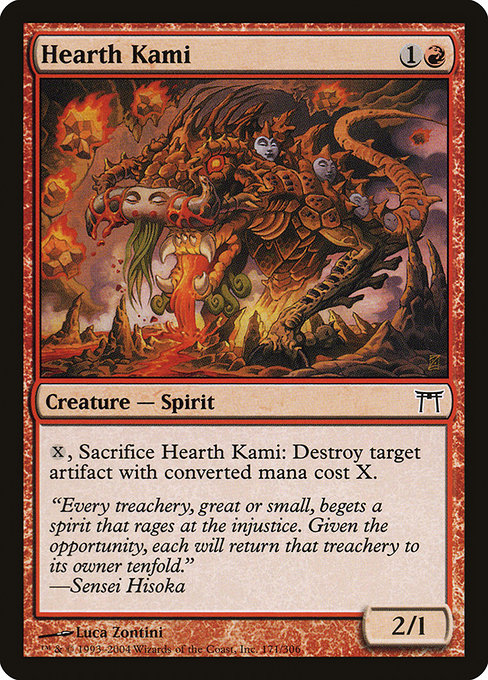

Displaying image: Hearth_Kami_CHK.jpg


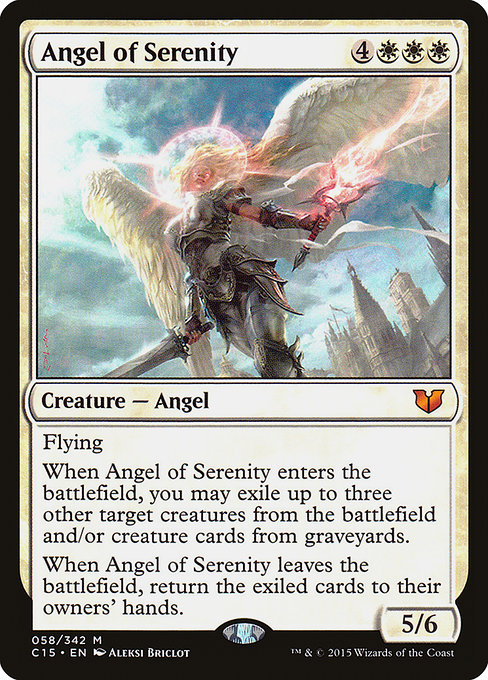

Displaying image: Angel_of_Serenity_C15.jpg


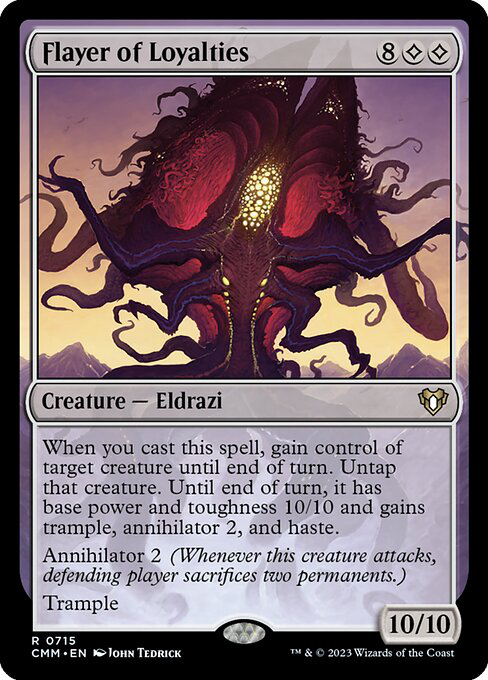

Displaying image: Flayer_of_Loyalties_CMM.jpg


In [ ]:
import os
import random
from PIL import Image
from IPython.display import display

# Define the directory where images are saved
output_dir = "creature_cards"

# Get a list of image files in the directory
image_files = os.listdir(output_dir)

# Choose a few random images to display
sample_images = random.sample(image_files, 3) 

# Display each selected image
for img_file in sample_images:
    img_path = os.path.join(output_dir, img_file)
    img = Image.open(img_path)
    display(img) 
    print(f"Displaying image: {img_file}")


## Set up the GAN architecture

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3 * 64 * 64),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.model(z)
        return out.view(-1, 3, 64, 64)


# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 64 * 64, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output probability
        )

    def forward(self, x):
        return self.model(x)


# Initialize models
latent_dim = 100
generator = Generator(latent_dim)
discriminator = Discriminator()

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))



## Train the GAN

In [11]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

num_epochs = 50
batch_size = 64
real_label = 1.0
fake_label = 0.0

for epoch in range(num_epochs):
    for i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)

        # Train Discriminator
        optimizer_d.zero_grad()

        # Real images
        real_labels = torch.full((real_images.size(0),), real_label, device=device)
        output_real = discriminator(real_images)
        loss_real = criterion(output_real.squeeze(), real_labels)

        # Fake images
        z = torch.randn(real_images.size(0), latent_dim, device=device)
        fake_images = generator(z)
        fake_labels = torch.full((real_images.size(0),), fake_label, device=device)
        output_fake = discriminator(fake_images.detach())
        loss_fake = criterion(output_fake.squeeze(), fake_labels)

        # Total discriminator loss
        loss_d = loss_real + loss_fake
        loss_d.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()
        output_fake = discriminator(fake_images)
        loss_g = criterion(output_fake.squeeze(), real_labels)
        loss_g.backward()
        optimizer_g.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(dataloader)}], "
                  f"D Loss: {loss_d.item():.4f}, G Loss: {loss_g.item():.4f}")

    # Save model checkpoints periodically
    if (epoch + 1) % 10 == 0:
        torch.save(generator.state_dict(), f"generator_epoch_{epoch+1}.pth")
        torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch+1}.pth")


Epoch [1/50], Step [0/138], D Loss: 1.3835, G Loss: 0.6782
Epoch [1/50], Step [100/138], D Loss: 0.4917, G Loss: 1.0661
Epoch [2/50], Step [0/138], D Loss: 2.0313, G Loss: 0.5106
Epoch [2/50], Step [100/138], D Loss: 0.4196, G Loss: 1.2969
Epoch [3/50], Step [0/138], D Loss: 0.2960, G Loss: 1.6333
Epoch [3/50], Step [100/138], D Loss: 0.3677, G Loss: 2.2020
Epoch [4/50], Step [0/138], D Loss: 1.4654, G Loss: 1.4853
Epoch [4/50], Step [100/138], D Loss: 0.4901, G Loss: 1.6833
Epoch [5/50], Step [0/138], D Loss: 0.6185, G Loss: 2.0385
Epoch [5/50], Step [100/138], D Loss: 0.4288, G Loss: 1.7610
Epoch [6/50], Step [0/138], D Loss: 1.9289, G Loss: 0.7520
Epoch [6/50], Step [100/138], D Loss: 0.5670, G Loss: 2.4460
Epoch [7/50], Step [0/138], D Loss: 1.1782, G Loss: 1.5231
Epoch [7/50], Step [100/138], D Loss: 0.7816, G Loss: 0.7133
Epoch [8/50], Step [0/138], D Loss: 0.8677, G Loss: 1.3509
Epoch [8/50], Step [100/138], D Loss: 0.9620, G Loss: 2.7095
Epoch [9/50], Step [0/138], D Loss: 0.80

## Save and Generate Images

C:\Users\cgrob\AppData\Local\Temp\ipykernel_14048\2021752620.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator_epoch_50.pt

Generated images saved to generated_images.png


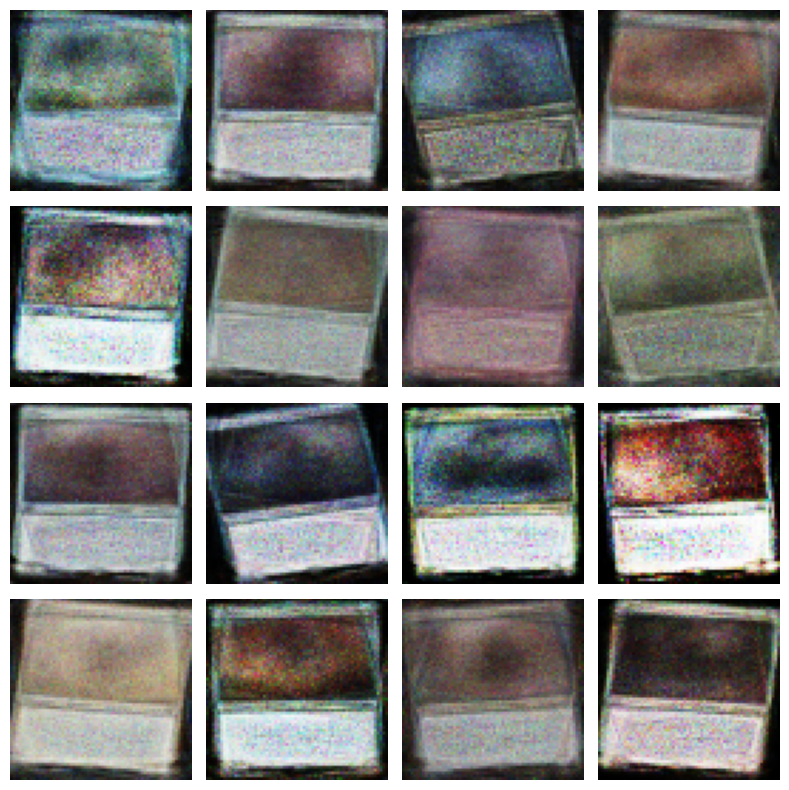

In [12]:
import matplotlib.pyplot as plt

# Function to generate and save images
def generate_images(generator, latent_dim, num_images=16, save_path="generated_images.png"):
    generator.eval() 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Generate latent vectors
    z = torch.randn(num_images, latent_dim, device=device)

    # Generate images
    with torch.no_grad():
        generated_images = generator(z).cpu()  

    # Denormalize images from [-1, 1] back to [0, 1]
    generated_images = (generated_images + 1) / 2

    # Plot images in a grid
    grid_size = int(num_images ** 0.5) 
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(8, 8))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(generated_images[i].permute(1, 2, 0)) 
        ax.axis("off")

    # Save the grid of images
    plt.tight_layout()
    plt.savefig(save_path)
    print(f"Generated images saved to {save_path}")
    plt.show()


# Example usage
generator.load_state_dict(torch.load("generator_epoch_50.pth", map_location=device)) 
generate_images(generator, latent_dim=100, num_images=16)


## Intermediate Conclusions:

The GAN did ok but could do better. I could try using other card types, but I will stick to creature cards for now since they are the most diverse. I'm surprised honestly. A simple GAN did pretty well and I'm surprised at the extent at which the model was able to recognize certain patterns like edges of the card, the colors, and even the power and toughness. But I do think I am not training enough. I would like to increase the number of epochs but it would take a lot of time. The training loop took 6 hours. 

Then I will try to do a DC GAN. 

Finally, I will try to do some evaluations. 

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
import torchvision.utils as vutils


## DC GAN Generator

In [14]:
# DC GAN Generator architecture
class DCGANGenerator(nn.Module):
    def __init__(self, latent_dim, num_channels=3):
        super(DCGANGenerator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


## DC GAN Discriminator

In [15]:
# DC GAN Discriminator architecture
class DCGANDiscriminator(nn.Module):
    def __init__(self, num_channels=3):
        super(DCGANDiscriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(num_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

## Training Loop Initializations

In [16]:
# Hyperparameters
latent_dim = 100
num_epochs = 50
lr = 0.0002
beta1 = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
netG = DCGANGenerator(latent_dim).to(device)
netD = DCGANDiscriminator().to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


## Training Loop

In [ ]:
# Training loop
for epoch in range(num_epochs):
    for i, real_images in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Train Discriminator
        netD.zero_grad()
        
        label_real = torch.ones(batch_size, device=device)
        output_real = netD(real_images)
        loss_real = criterion(output_real, label_real)

        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = netG(noise)
        label_fake = torch.zeros(batch_size, device=device)
        output_fake = netD(fake_images.detach())
        loss_fake = criterion(output_fake, label_fake)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        label_real = torch.ones(batch_size, device=device)
        output = netD(fake_images)
        loss_G = criterion(output, label_real)
        loss_G.backward()
        optimizerG.step()

        if i % 50 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(dataloader)}] "
                  f"Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

    # Save generated images
    with torch.no_grad():
        test_noise = torch.randn(64, latent_dim, 1, 1, device=device)
        generated_images = netG(test_noise).cpu()
        save_image(generated_images, f"generated_images_epoch_{epoch}.png", normalize=True)


Epoch [0/50] Batch [0/138] Loss D: 1.4781, Loss G: 2.9192
Epoch [0/50] Batch [50/138] Loss D: 0.8525, Loss G: 8.9265
Epoch [0/50] Batch [100/138] Loss D: 0.4699, Loss G: 3.3907
Epoch [1/50] Batch [0/138] Loss D: 0.4411, Loss G: 2.7885
Epoch [1/50] Batch [50/138] Loss D: 0.3797, Loss G: 3.6439
Epoch [1/50] Batch [100/138] Loss D: 0.5256, Loss G: 2.5723
Epoch [2/50] Batch [0/138] Loss D: 0.4170, Loss G: 3.8163
Epoch [2/50] Batch [50/138] Loss D: 0.4688, Loss G: 3.5405
Epoch [2/50] Batch [100/138] Loss D: 0.7647, Loss G: 2.9714
Epoch [3/50] Batch [0/138] Loss D: 0.6564, Loss G: 4.4593
Epoch [3/50] Batch [50/138] Loss D: 0.5611, Loss G: 2.9094
Epoch [3/50] Batch [100/138] Loss D: 0.6179, Loss G: 2.0920
Epoch [4/50] Batch [0/138] Loss D: 0.8013, Loss G: 2.7769
Epoch [4/50] Batch [50/138] Loss D: 0.3395, Loss G: 2.5280
Epoch [4/50] Batch [100/138] Loss D: 0.2716, Loss G: 4.1197
Epoch [5/50] Batch [0/138] Loss D: 0.8528, Loss G: 7.2363
Epoch [5/50] Batch [50/138] Loss D: 0.2298, Loss G: 3.203

## Generating Images

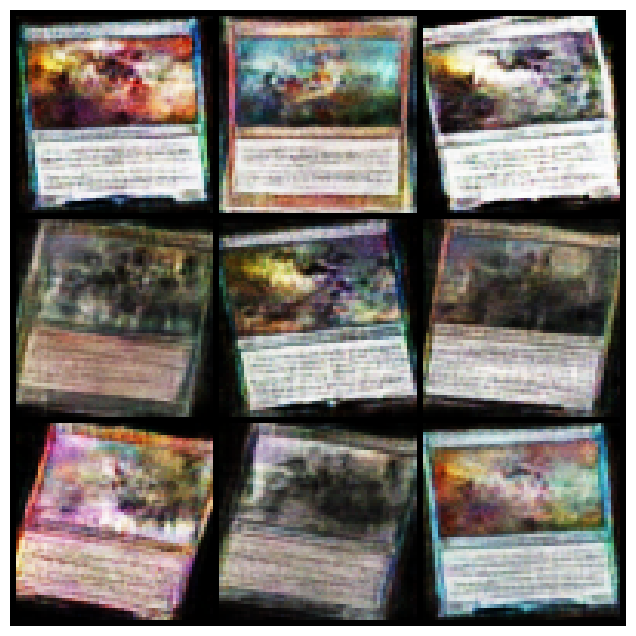

In [18]:
def generate_and_show_samples(generator, z_dim, device, num_samples=9):

    # Create a batch of random noise
    noise = torch.randn(num_samples, z_dim, 1, 1).to(device)
    
    # Generate images from the noise
    with torch.no_grad():
        fake_images = generator(noise)
    
    # Generate a grid of images (9 images in a 3x3 grid)
    grid = vutils.make_grid(fake_images, nrow=3, padding=2, normalize=True)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off') 
    plt.show()

generate_and_show_samples(netG, z_dim=100, device=device, num_samples=9)


## Conclusions

After 423 minutes to train the GAN and 535 minutes to train the DCGAN, I finally arrived to some generated images and conclusions. The generated images from the GAN were not bad. I was very impressed how a simple GAN could understand at least the structure of the card. There were still hazy ones which I believe is because of short training, but I was impressed (mostly at what I had accomplished). The DCGAN was even more surprising. Aftering squinting, they look like real cards. There is some variance in color/art and some cards even look foiled. After a lengthy training, the DCGAN was still not able to pick up on the power and toughness of creatures. It appears it has picked up on set symbols (top left, middle, bottom right) but not so much on the power and toughness. 

### Limitations:

I wasn't able to use a decently balanced dataset. Data mining took a while to get right but data cleaning may have taken even longer if I had took the time to do it. The script that mined the data just went through the database and requested card images alphabetically and indiscriminately. If I had coded better, or if I could access some of the metadata as well, I have been able to stratify and sample only the newer cards or ones that don't fit the creature type structure, or have the same number of cards for each color combination. 

### Next time:

I want to learn more about STYLE GANs and how to use my GPU during training. Taking nearly 16 hours to train is not quite ideal. I wouldn't call this a failure but I was still impressed. 